In [3]:

import torch
import numpy as np
import pandas as pd
import torch.nn as nn

from torchvision import models,datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchsummary import summary
from torchvision.utils import make_grid
from torchvision.datasets import STL10
import itertools
import torch.optim as optim
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from torch.utils.data import  random_split, DataLoader

from fastai.vision.all import *

Cargamos el dataset (api de kaggle)

In [5]:
!pip install opencv-python pillow

In [6]:
!pip install kaggle

In [8]:

import opendatasets as od
dataset_link = "https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ricardojairodazbarrn
Your Kaggle Key: ··········


100%|██████████| 82.0M/82.0M [00:05<00:00, 16.3MB/s]


In [12]:
dataset_dir = "/content/garbage-classification/Garbage classification/Garbage classification"


transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((96,96)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: (x * 2) - 1)
])



dataset = datasets.ImageFolder(root= dataset_dir, transform = transform)


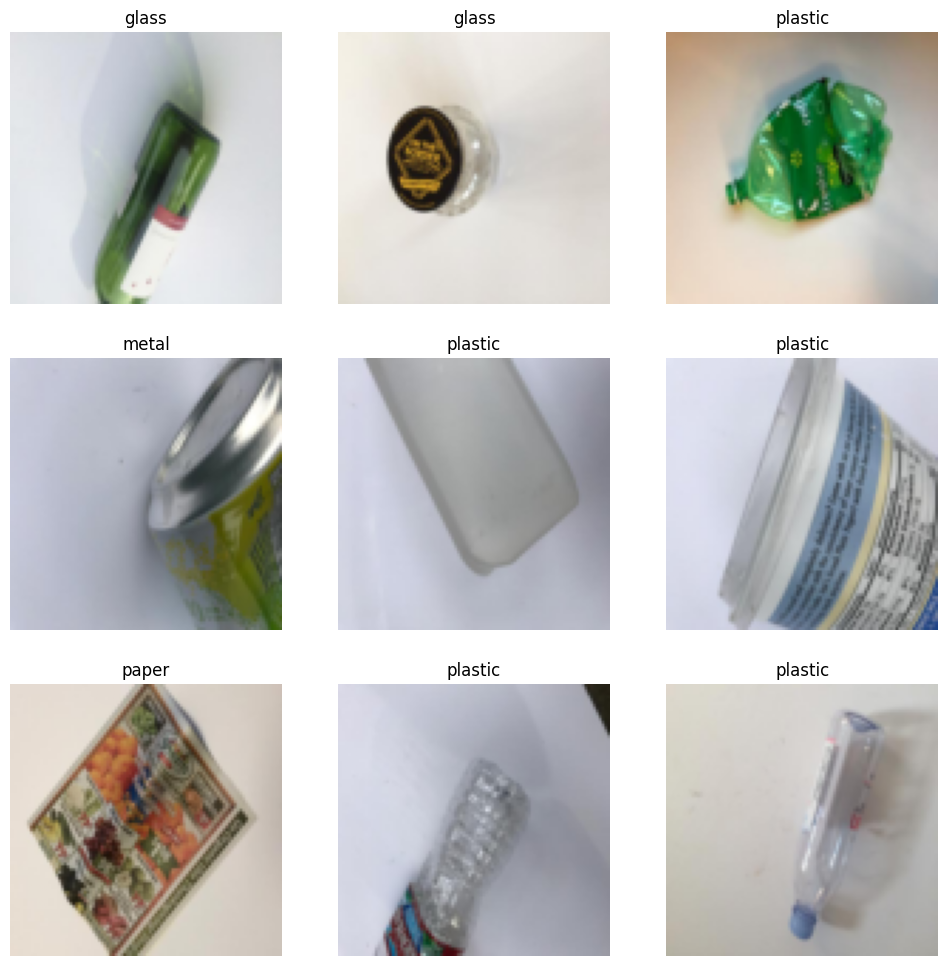

In [17]:
classes= ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

fig, axs = plt.subplots(3,3, figsize=(12,12))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(dataset)-1)
        img, lab = dataset[ix]
        ax.imshow(((img+1)/2).permute(1,2,0))
        ax.axis('off')
        ax.set_title(classes[lab])
plt.show()

In [19]:

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
print('train size:',train_size)
print('test size:',test_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
# Se crea dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False)
dataloader = {
    'train': train_loader,
    'test': test_loader
}



train size: 1768
test size: 759


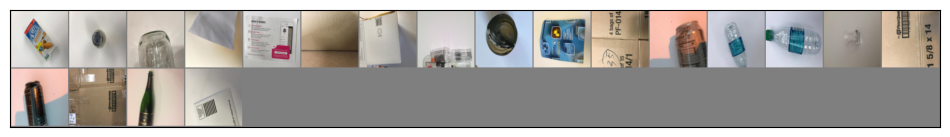

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0)*0.5+0.5)
        break
show_batch(dataloader['train'])

In [11]:
imgs, labels = next(iter(train_loader))
print('Forma Xi:',imgs.shape)


Forma Xi: torch.Size([20, 3, 96, 96])


In [9]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.6 MB/s eta 0:00:00


In [29]:
import timm
#importación del paquete timm (Torch Image Models).
# Carga el modelo RegNet
regnet_model = timm.create_model("regnetx_002", pretrained=True)
#15 capas de convolución, cada una con un kernel de 3x3 y un padding de 1 píxel.

In [31]:
print(regnet_model)

RegNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (s1): RegStage(
    (b1): Bottleneck(
      (conv1): ConvNormAct(
        (conv): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (conv2): ConvNormAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (se): Identity()
      (conv3): ConvNormAct(
     

In [11]:

import torch.nn as nn
import torch

class ModelCustom(nn.Module):
    def __init__(self, n_outputs=10, pretrained=False, freeze=False):
        super(ModelCustom, self).__init__()

        # Carga el modelo RegNet más simple (puede que necesites especificar exactamente qué variante de RegNet deseas, aquí es un ejemplo)
        self.regnet = timm.create_model("regnetx_002", pretrained=pretrained)

        # Elimina la última capa (clasificación) del RegNet
        self.features = nn.Sequential(*list(self.regnet.children())[:-1])

        if freeze:
            for param in self.features.parameters():
                param.requires_grad = False

        # Aquí, puedes necesitar ajustar la dimensión de entrada según el modelo RegNet específico que elijas
        self.fc = nn.Linear(3312, n_outputs)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def unfreeze(self):
        for param in self.features.parameters():
            param.requires_grad = True



In [12]:
from tqdm import tqdm
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=3, lr=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #Adam tiende a converger rápidamente y es menos sensible a la inicialización de la tasa de aprendizaje,
    # en comparación con optimizadores como SGD.
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.cuda(), y.cuda()
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.cuda(), y.cuda()
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
        # torch.save(model.state_dict(), f'/content/drive/MyDrive/SIS421/Preg5Train/Modelmix_{epoch}.pth')

In [17]:
# Transfer Learnign.......iiii....lllll................................
model_c = ModelCustom(pretrained=True, freeze=True).cuda()
fit(model_c, dataloader, epochs=15, lr=1e-4)

val_loss 1.20664 val_acc 0.55734: 100%|██████████| 38/38 [00:02<00:00, 17.71it/s]


Epoch 1/15 loss 1.59186 val_loss 1.20664 acc 0.39354 val_acc 0.55734


val_loss 0.97339 val_acc 0.65360: 100%|██████████| 38/38 [00:02<00:00, 12.92it/s]


Epoch 2/15 loss 1.07163 val_loss 0.97339 acc 0.60534 val_acc 0.65360


val_loss 0.87870 val_acc 0.69584: 100%|██████████| 38/38 [00:02<00:00, 17.50it/s]


Epoch 3/15 loss 0.89589 val_loss 0.87870 acc 0.66854 val_acc 0.69584


val_loss 0.82022 val_acc 0.70630: 100%|██████████| 38/38 [00:02<00:00, 17.88it/s]


Epoch 4/15 loss 0.81403 val_loss 0.82022 acc 0.71742 val_acc 0.70630


val_loss 0.76837 val_acc 0.74051: 100%|██████████| 38/38 [00:02<00:00, 16.78it/s]


Epoch 5/15 loss 0.74342 val_loss 0.76837 acc 0.73062 val_acc 0.74051


val_loss 0.76704 val_acc 0.74183: 100%|██████████| 38/38 [00:02<00:00, 17.71it/s]


Epoch 6/15 loss 0.66818 val_loss 0.76704 acc 0.76882 val_acc 0.74183


val_loss 0.73870 val_acc 0.73386: 100%|██████████| 38/38 [00:02<00:00, 15.40it/s]


Epoch 7/15 loss 0.63454 val_loss 0.73870 acc 0.79213 val_acc 0.73386


val_loss 0.71842 val_acc 0.75623: 100%|██████████| 38/38 [00:02<00:00, 17.49it/s]


Epoch 8/15 loss 0.58711 val_loss 0.71842 acc 0.81039 val_acc 0.75623


val_loss 0.72853 val_acc 0.74439: 100%|██████████| 38/38 [00:02<00:00, 17.86it/s]


Epoch 9/15 loss 0.57305 val_loss 0.72853 acc 0.80646 val_acc 0.74439


val_loss 0.71599 val_acc 0.75097: 100%|██████████| 38/38 [00:03<00:00,  9.50it/s]


Epoch 10/15 loss 0.54048 val_loss 0.71599 acc 0.80197 val_acc 0.75097


val_loss 0.69401 val_acc 0.74965: 100%|██████████| 38/38 [00:02<00:00, 17.23it/s]


Epoch 11/15 loss 0.52489 val_loss 0.69401 acc 0.82500 val_acc 0.74965


val_loss 0.66684 val_acc 0.77597: 100%|██████████| 38/38 [00:02<00:00, 17.37it/s]


Epoch 12/15 loss 0.49582 val_loss 0.66684 acc 0.82809 val_acc 0.77597


val_loss 0.72043 val_acc 0.75097: 100%|██████████| 38/38 [00:03<00:00, 12.47it/s]


Epoch 13/15 loss 0.46622 val_loss 0.72043 acc 0.84382 val_acc 0.75097


val_loss 0.68715 val_acc 0.76281: 100%|██████████| 38/38 [00:02<00:00, 17.79it/s]


Epoch 14/15 loss 0.45062 val_loss 0.68715 acc 0.85337 val_acc 0.76281


val_loss 0.66063 val_acc 0.76939: 100%|██████████| 38/38 [00:02<00:00, 17.33it/s]

Epoch 15/15 loss 0.44175 val_loss 0.66063 acc 0.86264 val_acc 0.76939


In [18]:
# Transfer Learnign.......iiii....lllll
model_c = ModelCustom(pretrained=True, freeze=True).cuda()
fit(model_c, dataloader, epochs=5)
model_c.unfreeze()
fit(model_c, dataloader, epochs=5,lr=1e-4)

val_loss 50.52481 val_acc 0.65464: 100%|██████████| 38/38 [00:02<00:00, 12.97it/s]


Epoch 1/5 loss 74.18396 val_loss 50.52481 acc 0.51882 val_acc 0.65464


val_loss 60.12327 val_acc 0.67701: 100%|██████████| 38/38 [00:02<00:00, 14.42it/s]


Epoch 2/5 loss 44.98258 val_loss 60.12327 acc 0.67107 val_acc 0.67701


val_loss 60.39580 val_acc 0.67846: 100%|██████████| 38/38 [00:02<00:00, 17.65it/s]


Epoch 3/5 loss 44.82608 val_loss 60.39580 acc 0.70449 val_acc 0.67846


val_loss 83.87996 val_acc 0.66274: 100%|██████████| 38/38 [00:02<00:00, 13.20it/s]


Epoch 4/5 loss 39.24168 val_loss 83.87996 acc 0.74663 val_acc 0.66274


val_loss 66.26003 val_acc 0.69668: 100%|██████████| 38/38 [00:02<00:00, 17.88it/s]


Epoch 5/5 loss 35.61610 val_loss 66.26003 acc 0.78202 val_acc 0.69668


val_loss 47.05858 val_acc 0.75741: 100%|██████████| 38/38 [00:02<00:00, 17.17it/s]


Epoch 1/5 loss 20.52196 val_loss 47.05858 acc 0.83820 val_acc 0.75741


val_loss 41.07222 val_acc 0.78109: 100%|██████████| 38/38 [00:02<00:00, 17.97it/s]


Epoch 2/5 loss 10.76480 val_loss 41.07222 acc 0.89691 val_acc 0.78109


val_loss 44.17219 val_acc 0.77569: 100%|██████████| 38/38 [00:03<00:00, 12.51it/s]


Epoch 3/5 loss 6.93805 val_loss 44.17219 acc 0.92416 val_acc 0.77569


val_loss 40.93596 val_acc 0.77320: 100%|██████████| 38/38 [00:02<00:00, 17.77it/s]


Epoch 4/5 loss 5.65585 val_loss 40.93596 acc 0.93202 val_acc 0.77320


val_loss 37.31253 val_acc 0.79564: 100%|██████████| 38/38 [00:02<00:00, 17.35it/s]

Epoch 5/5 loss 4.62121 val_loss 37.31253 acc 0.94101 val_acc 0.79564


Mejora pero no es suficiente entonces aplicamos data augmentation

In [14]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance

# Ruta al directorio del dataset descargado
dataset_path = './garbage-classification/Garbage classification/Garbage classification'

# Definimos las transformaciones como funciones individuales
def original(image):
    return image

def rotar_90(image):
    return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

def espejo_h(image):
    return cv2.flip(image, 1)

def aumento_brillo(image):
    pil_image = Image.fromarray(image)
    enhancer = ImageEnhance.Brightness(pil_image)
    return enhancer.enhance(1.8)

def aumento_contraste(image):
    pil_image = Image.fromarray(image)
    enhancer = ImageEnhance.Contrast(pil_image)
    return enhancer.enhance(1.5)

transformations = [rotar_90, espejo_h, aumento_brillo, aumento_contraste]

# Copias de cada transformación
copias_por_transformacion = 4

# Recorremos las subcarpetas del directorio
for etiqueta in os.listdir(dataset_path):
    path_etiqueta = os.path.join(dataset_path, etiqueta)

    # Verifica si es un directorio
    if os.path.isdir(path_etiqueta):

        # Recorre las imágenes de cada subcarpeta
        for archivo_imagen in os.listdir(path_etiqueta):
            ruta_imagen = os.path.join(path_etiqueta, archivo_imagen)

            # Lee la imagen
            imagen = cv2.imread(ruta_imagen)

            # Aplica las transformaciones
            for idx, transform_func in enumerate(transformations):
                img_transformada = transform_func(imagen)

                if isinstance(img_transformada, Image.Image):
                    img_transformada = np.array(img_transformada)

                # Crea un nombre para la imagen transformada
                nombre_imagen_transformada = f"{idx}_{archivo_imagen}"
                ruta_img_transformada = os.path.join(path_etiqueta, nombre_imagen_transformada)

                # Guarda la imagen transformada
                cv2.imwrite(ruta_img_transformada, img_transformada)

In [15]:
import os
from collections import Counter

# Ruta al directorio raíz que contiene las carpetas con archivos
root_dir = "/content/garbage-classification/Garbage classification/Garbage classification"

# Obtener una lista de todas las carpetas dentro del directorio raíz
subdirectories = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Recorre cada carpeta y cuenta las extensiones de archivo únicas
for folder_name in subdirectories:
    folder_path = os.path.join(root_dir, folder_name)

    # Obtén una lista de todos los archivos en la carpeta
    file_list = os.listdir(folder_path)

    # Extrae las extensiones de archivo de la lista de archivos
    file_extensions = [os.path.splitext(file)[1] for file in file_list]

    # Usa Counter para contar las extensiones de archivo únicas
    extension_counter = Counter(file_extensions)

    # Imprime las extensiones de archivo y sus recuentos
    print(f"En la carpeta '{folder_name}':")
    for extension, count in extension_counter.items():
        print(f"   Tipo de archivo: {extension}, Cantidad: {count}")
    print()

En la carpeta 'glass':
   Tipo de archivo: .jpg, Cantidad: 2505

En la carpeta 'cardboard':
   Tipo de archivo: .jpg, Cantidad: 2015

En la carpeta 'paper':
   Tipo de archivo: .jpg, Cantidad: 2970

En la carpeta 'plastic':
   Tipo de archivo: .jpg, Cantidad: 2410

En la carpeta 'metal':
   Tipo de archivo: .jpg, Cantidad: 2050

En la carpeta 'trash':
   Tipo de archivo: .jpg, Cantidad: 685



In [16]:
dataset_dir = "/content/garbage-classification/Garbage classification/Garbage classification"
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((96,96)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: (x * 2) - 1)
])
dataset = datasets.ImageFolder(root= dataset_dir, transform = transform)

In [17]:
len(dataset)

12635

In [24]:
imgs, labels = next(iter(train_loader))
print('Forma Xi:',imgs.shape)


Forma Xi: torch.Size([20, 3, 96, 96])


In [18]:

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
print('train size:',train_size)
print('test size:',test_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
# Se crea dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
dataloader2 = {
    'train': train_loader,
    'test': test_loader
}


train size: 8844
test size: 3791


In [29]:
# Transfer Learnign y fine tunning
model_c2 = ModelCustom(pretrained=True, freeze=True).cuda()
fit(model_c2, dataloader2, epochs=4)
model_c2.unfreeze()
fit(model_c2, dataloader2, epochs=9,lr=1e-4)

val_loss 38.02184 val_acc 0.66177: 100%|██████████| 60/60 [00:10<00:00,  5.71it/s]


Epoch 1/4 loss 54.50335 val_loss 38.02184 acc 0.59903 val_acc 0.66177


val_loss 42.77307 val_acc 0.66587: 100%|██████████| 60/60 [00:11<00:00,  5.38it/s]


Epoch 2/4 loss 27.17356 val_loss 42.77307 acc 0.71557 val_acc 0.66587


val_loss 37.57025 val_acc 0.71000: 100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


Epoch 3/4 loss 27.05358 val_loss 37.57025 acc 0.73205 val_acc 0.71000


val_loss 28.73467 val_acc 0.74366: 100%|██████████| 60/60 [00:11<00:00,  5.38it/s]


Epoch 4/4 loss 23.02748 val_loss 28.73467 acc 0.77672 val_acc 0.74366


val_loss 15.42873 val_acc 0.82550: 100%|██████████| 60/60 [00:11<00:00,  5.28it/s]


Epoch 1/9 loss 10.29138 val_loss 15.42873 acc 0.86211 val_acc 0.82550


val_loss 12.45986 val_acc 0.84868: 100%|██████████| 60/60 [00:11<00:00,  5.24it/s]


Epoch 2/9 loss 3.79705 val_loss 12.45986 acc 0.92296 val_acc 0.84868


val_loss 11.74097 val_acc 0.86444: 100%|██████████| 60/60 [00:12<00:00,  4.99it/s]


Epoch 3/9 loss 2.36784 val_loss 11.74097 acc 0.94668 val_acc 0.86444


val_loss 10.00481 val_acc 0.87623: 100%|██████████| 60/60 [00:10<00:00,  5.51it/s]


Epoch 4/9 loss 1.76540 val_loss 10.00481 acc 0.96204 val_acc 0.87623


val_loss 9.43784 val_acc 0.87844: 100%|██████████| 60/60 [00:11<00:00,  5.24it/s]


Epoch 5/9 loss 1.45198 val_loss 9.43784 acc 0.96763 val_acc 0.87844


val_loss 8.84816 val_acc 0.88755: 100%|██████████| 60/60 [00:12<00:00,  4.89it/s]


Epoch 6/9 loss 1.01945 val_loss 8.84816 acc 0.97141 val_acc 0.88755


val_loss 8.39374 val_acc 0.89283: 100%|██████████| 60/60 [00:10<00:00,  5.61it/s]


Epoch 7/9 loss 0.79805 val_loss 8.39374 acc 0.97932 val_acc 0.89283


val_loss 8.03932 val_acc 0.89491: 100%|██████████| 60/60 [00:11<00:00,  5.30it/s]


Epoch 8/9 loss 0.66662 val_loss 8.03932 acc 0.98156 val_acc 0.89491


val_loss 7.51060 val_acc 0.90012: 100%|██████████| 60/60 [00:11<00:00,  5.37it/s]

Epoch 9/9 loss 0.71613 val_loss 7.51060 acc 0.97823 val_acc 0.90012


In [20]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

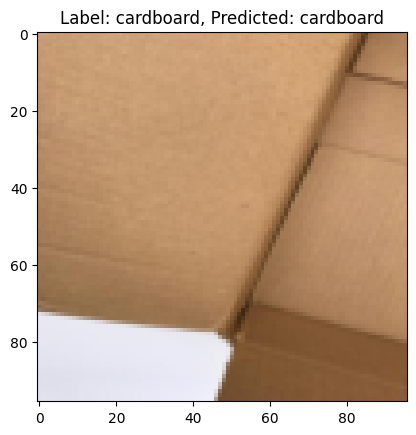

In [25]:
# Obtener el 18vo lote (index 17) del conjunto de prueba
for i, (imgs, labels) in enumerate(dataloader2['test']):
    if i == 17:
        img, label = imgs[0], labels[0]  # Tomamos la primera imagen y etiqueta del lote
        break

# Visualizar la imagen
plt.imshow(img.permute(1, 2, 0)*0.5+0.5)
plt.title(f'Label: {dataset.classes[label.item()]}, Predicted: {predict_image(img, model_c2)}')
plt.show()

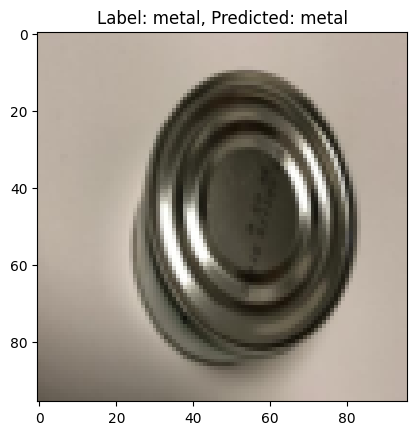

In [26]:
# Obtener el 18vo lote (index 17) del conjunto de prueba
for i, (imgs, labels) in enumerate(dataloader2['test']):
    if i == 17:
        img, label = imgs[1], labels[1]  # Tomamos la primera imagen y etiqueta del lote
        break

# Visualizar la imagen
plt.imshow(img.permute(1, 2, 0)*0.5+0.5)
plt.title(f'Label: {dataset.classes[label.item()]}, Predicted: {predict_image(img, model_c2)}')
plt.show()

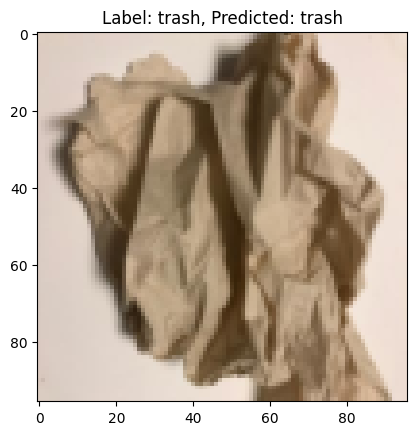

In [28]:
# Obtener el 18vo lote (index 17) del conjunto de prueba
for i, (imgs, labels) in enumerate(dataloader2['test']):
    if i == 17:
        img, label = imgs[4], labels[4]  # Tomamos la primera imagen y etiqueta del lote
        break

# Visualizar la imagen
plt.imshow(img.permute(1, 2, 0)*0.5+0.5)
plt.title(f'Label: {dataset.classes[label.item()]}, Predicted: {predict_image(img, model_c2)}')
plt.show()